In [8]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.optimizers import Adam
import joblib
from matplotlib import pyplot as plt

USER_ID = 353
PATH_DATA = 'data/user_sequences/'
EXTENSION_TEXT = '.txt'
PATH_USER_DATA = PATH_DATA + f'user_{USER_ID}_sequence' + EXTENSION_TEXT

data = pd.read_csv(PATH_USER_DATA, header=None)
data = data.to_numpy()[:,1:]  # Discard weekday, just for now
print(data.shape)

(240, 2)


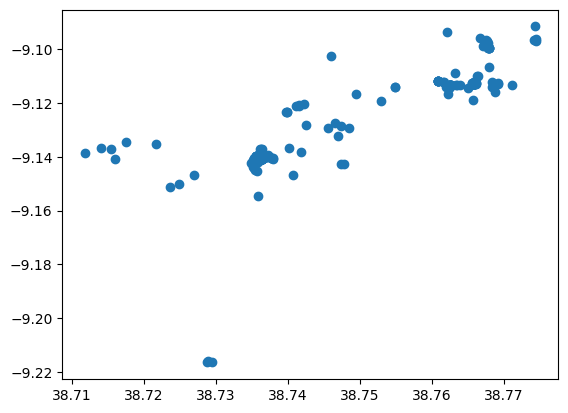

In [9]:
lat = data[:, 0]
lon = data[:, 1]

plt.scatter(lat, lon)
plt.show()

In [10]:
"""

scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

lat = data_scaled[:, 0]
lon = data_scaled[:, 1]

plt.scatter(lat, lon)
plt.show()
"""

'\n\nscaler = StandardScaler()\n#scaler = MinMaxScaler()\nscaler.fit(data)\ndata_scaled = scaler.transform(data)\n\nlat = data_scaled[:, 0]\nlon = data_scaled[:, 1]\n\nplt.scatter(lat, lon)\nplt.show()\n'

[ 0  0  0  0 -1  1  1  1  1  1  0  0  0  0  0  1  1  2  0  0  0  0  0  3
  1  1  1  0  0  3  1  1  1  1  1  3  0  0  1 -1  0  0  0  0 -1  0  1  1
  1  3  0  0  1  1  0  0  0 -1  2  1  2  0  0  0  0  1  1  1  0  0 -1  1
  1  0  1  1  1  1  2  0  0  0  0  1  1  1  1  3  0  1  1  1  1  0 -1  1
  1  1  0 -1  1  1  1  0  1  1  1  1 -1  0 -1  1  1  1  1  1 -1 -1 -1  1
 -1  1  2  2  2  1  1  1 -1 -1 -1 -1  1  1  1  1  1 -1  2 -1  1  0 -1  1
 -1 -1  1  0  0  0  1  1  1  1 -1  0  1  1  1  1  0  0  0  0  1  1  3 -1
  1  0  0 -1  1  1  2  0  0  0  0  0 -1  1  1  2 -1  0  0  0  0  0 -1  2
  1  3  0  0  0  0  0 -1  1  1  1 -1  0  1  1  0  0 -1  1 -1  0  0  0  0
  0  2  1  1  2  1 -1  0  0  0  1  1  1  1  1  0  0  0  1  0  0  0  0  1]
[1 1 1 1 0 2 2 2 2 2 1 1 1 1 1 2 2 3 1 1 1 1 1 4 2 2 2 1 1 4 2 2 2 2 2 4 1
 1 2 0 1 1 1 1 0 1 2 2 2 4 1 1 2 2 1 1 1 0 3 2 3 1 1 1 1 2 2 2 1 1 0 2 2 1
 2 2 2 2 3 1 1 1 1 2 2 2 2 4 1 2 2 2 2 1 0 2 2 2 1 0 2 2 2 1 2 2 2 2 0 1 0
 2 2 2 2 2 0 0 0 2 0 2 3 3 3 2 2 2 0 0 0 0 2

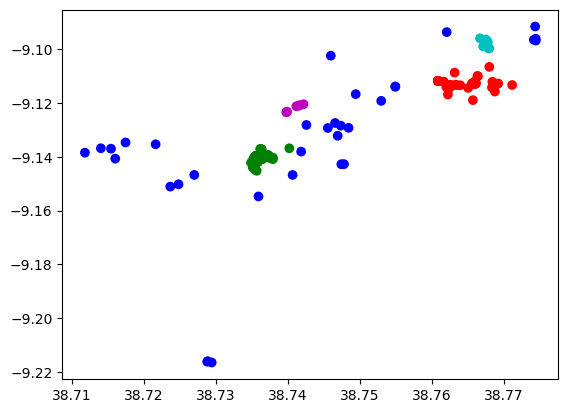

In [11]:
meters = 20000
eps = meters / 6371000

dbscan = DBSCAN(eps=eps, min_samples=7, metric='haversine')

labels = dbscan.fit_predict(data)
print(labels)
min = np.min(labels)
labels = labels + abs(min)
print(labels)
print(max(labels))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

col = [colors[i] for i in labels]


lat = data[:, 0]
lon = data[:, 1]

plt.scatter(lat, lon, color=col)
plt.show()

In [12]:
kf = KFold(n_splits=8)
sequence_length = 3
epochs = 100

n_classes = len(np.unique(labels))

best_score = 10
best_model = None
best_test_index = None

for train_index, test_index in kf.split(labels):
    X_train = labels[train_index]
    y_train = labels[train_index]
    X_test = labels[test_index]
    y_test = labels[test_index]

    train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=1)
    test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=1)

    optimizer = Adam(learning_rate=0.001) #Default = 0.001

    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(sequence_length, 1), return_sequences=True, activation=None))
    #lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(50, activation=None))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer=optimizer, loss='mse')

    lstm_history = lstm_model.fit(train_generator, epochs=epochs, verbose=1, batch_size=1)

    lstm_score = lstm_model.evaluate(test_generator, verbose=0, batch_size=1)

    print(f'LSTM SCORE: {lstm_score}')

    if lstm_score < best_score:
        best_score = lstm_score
        best_model = lstm_model
        best_test_index = test_index

Epoch 1/100
207/207 [==============================] - 2s 2ms/step - loss: 1.2649
Epoch 2/100
207/207 [==============================] - 0s 2ms/step - loss: 0.9683
Epoch 3/100
207/207 [==============================] - 0s 2ms/step - loss: 0.8995
Epoch 4/100
207/207 [==============================] - 0s 2ms/step - loss: 0.8857
Epoch 5/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8484
Epoch 6/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8309
Epoch 7/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8244
Epoch 8/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8467
Epoch 9/100
207/207 [==============================] - 0s 2ms/step - loss: 0.8368
Epoch 10/100
207/207 [==============================] - 0s 2ms/step - loss: 0.8222
Epoch 11/100
207/207 [==============================] - 1s 2ms/step - loss: 0.8419
Epoch 12/100
207/207 [==============================] - 0s 2ms/step - loss: 0.8086
Epoch 13/100


In [28]:
pred_index = 15

print(f'Best score: {best_score}')
print(f'Test Index: {best_test_index}')

pred_X = np.expand_dims(labels[pred_index:pred_index + sequence_length], 0)
pred = best_model.predict(pred_X)
print(f'Predicted: {pred}')
print(f'True: {labels[pred_index + sequence_length + 1]}')

#best_model.save('..\\models\\test\\model.h5')

Best score: 0.42203399538993835
Test Index: [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239]
1/1 [==============================] - 0s 18ms/step
Predicted: [[1.3888102]]
True: 1


In [14]:
pred_X = np.expand_dims(labels, 0)
pred = best_model.predict(pred_X)

print(labels)
print(pred)

1/1 [==============================] - 0s 218ms/step
[1 1 1 1 0 2 2 2 2 2 1 1 1 1 1 2 2 3 1 1 1 1 1 4 2 2 2 1 1 4 2 2 2 2 2 4 1
 1 2 0 1 1 1 1 0 1 2 2 2 4 1 1 2 2 1 1 1 0 3 2 3 1 1 1 1 2 2 2 1 1 0 2 2 1
 2 2 2 2 3 1 1 1 1 2 2 2 2 4 1 2 2 2 2 1 0 2 2 2 1 0 2 2 2 1 2 2 2 2 0 1 0
 2 2 2 2 2 0 0 0 2 0 2 3 3 3 2 2 2 0 0 0 0 2 2 2 2 2 0 3 0 2 1 0 2 0 0 2 1
 1 1 2 2 2 2 0 1 2 2 2 2 1 1 1 1 2 2 4 0 2 1 1 0 2 2 3 1 1 1 1 1 0 2 2 3 0
 1 1 1 1 1 0 3 2 4 1 1 1 1 1 0 2 2 2 0 1 2 2 1 1 0 2 0 1 1 1 1 1 3 2 2 3 2
 0 1 1 1 2 2 2 2 2 1 1 1 2 1 1 1 1 2]
[[nan]]
